In [2]:
using Pkg
using LinearAlgebra
using Random
using Plots
using Dates

In [3]:
function readGraph(file)
    """
    Lecture du fichier et creation structure de read_graph
    """
    fileRead=open(file,"r")
    lines=readlines(fileRead)
    AdjList=Dict{Int,Vector{Int}}()
    n=0;
    for line in lines
        str=split(line," ")
        if(str[1]=="e")
            u=parse(Int,str[2])
            v=parse(Int,str[3])
            if haskey(AdjList,u)
                push!(AdjList[u],v)
            else
                AdjList[u]=[v]
            end

            if haskey(AdjList,v)
                push!(AdjList[v],u)
            else
                AdjList[v]=[u]
            end
        end
        if(str[1]=="p")
            n=parse(Int,str[3])
        end
    end
        return AdjList,n

end    



readGraph (generic function with 1 method)

In [4]:
function randomColoring(n,k,seed=0)
    """
    Random coloring
    """
    Random.seed!(seed)
    return rand(1:k,n)
end

randomColoring (generic function with 2 methods)

In [5]:
function availableColor(adjecenceList,Colors,k,u)
    """
        Choisir une couleur disponible pour la sommet u
    """
    nbUsesColor=zeros(Int,k)
    for v in adjecenceList[u]
        if Colors[v]!=0
            nbUsesColor[Colors[v]]+=1
        end
    end
    for color in 1:k
        if(nbUsesColor[color]==0)
            return color
        end
    end
    return argmin(nbUsesColor)
end

availableColor (generic function with 1 method)

In [6]:
function glouton(adjecenceList,sommetSortDegree,n,k)
    """
        Glouton algorithm
    """

    Colors=zeros(Int,n)
    for i in sommetSortDegree
        Colors[i]=availableColor(adjecenceList,Colors, k ,i)
    end
    return Colors
end

glouton (generic function with 1 method)

In [7]:
function countConflict(adjecenceList, Colors, n)
"""
    Compter les conflits
"""
    count=0;
    for u in 1:n
        for v in adjecenceList[u]
            if(Colors[u]==Colors[v])
                count+=1
            end
        end
    end
    return count/2; 
end

countConflict (generic function with 1 method)

In [8]:
function tournament(Parents,tournamentSize,popSize)
    """
        Faire tournement de taille tournamentSize
    """
    indexCandidats=rand(1:popSize,tournamentSize)
    candidats=Parents[indexCandidats]
    sort!(candidats, by=x->x[2])
    return candidats[1]
end

tournament (generic function with 1 method)

In [9]:
function crossover(Parents,AdjList, n)

    """
    1 point crossover pour les parents selectionnes dans Parents
    """
    enfants=[]
    
    while true
        if length(Parents)==0
            break
        end

        if length(Parents)==1
            push!(enfants,Parents[1])
            break
        end
        
        indexA=rand(1:length(Parents))
        parentA=Parents[indexA][1]
        deleteat!(Parents,indexA)
        indexB=rand(1:length(Parents))
        parentB=Parents[indexB][1]
        deleteat!(Parents,indexB)

        seuil=rand(1:(length(parentA)-1))
        child1=parentA[1:seuil]
        append!(child1,parentB[seuil+1:end])
        child2=parentB[1:seuil];
        append!(child2,parentA[seuil+1:end])

        push!(enfants,(child1,countConflict(AdjList,child1,n)))
        push!(enfants,(child2,countConflict(AdjList,child2,n)))
    end 
    return enfants
    
end

crossover (generic function with 1 method)

In [10]:
function mutation2(generation,AdjList, probMutation, n,k)
    """
        Mutation with probMutation
    """
    newGeneration=[]
    for (i,chromosome) in enumerate(generation)
        newChromosome=chromosome[1]
        # change aleatoir. couleur de sommet 
        for u= 1:n
            p=rand()
            if p<probMutation
                available_colors = setdiff(1:k, [newChromosome[n] for n in AdjList[u]])
                if !isempty(available_colors)
                    # If there are available colors, choose one randomly
                    newChromosome[u] = rand(available_colors)
                else
                    # If no available colors, revert to a random valid color
                    newChromosome[u] = rand(1:k)
                end
            
            end
        end
        # verifie, que ca nous donne qqch bon
        for u=1:n
            needChange=false
            for v in AdjList[u]
                if newChromosome[v]==newChromosome[u]
                    needChange=true
                    break;
                end
            end
            if needChange
                newChromosome[u]=availableColor(AdjList,newChromosome,k,u)
            end
             
        end
        cnflct=countConflict(AdjList,newChromosome,n)
        push!(newGeneration,(newChromosome,cnflct))
    end

    return newGeneration;
end

mutation2 (generic function with 1 method)

In [121]:
function trouver_indice(r, p)
    """
        Trouver indice de parent qu'on choisi
    """
    somme_cumulative = 0.0
    n = length(p)
    
    for i in 1:n
        somme_cumulative += p[i]
        if r <= somme_cumulative
            return i
        end
    end
    
    # Si r dépasse toutes les sommes cumulatives, retourne -1 ou une valeur indiquant que rien n'a été trouvé.
    return -1
end

function roueFortune_index(generation, n, probCrossover,enfantsSize)
    """
        Roue de fortune, qui retourne index
    """
    index_parents=[]
    F=sum(pair[2] for pair in generation)
    probaGeneration=Float64[(F-pair[2])/((n-1)*F) for pair in generation]

    for i in 1:enfantsSize
        r=rand()
        index=trouver_indice(r,probaGeneration)
        push!(index_parents,index)
    end
    return index_parents
end

function roueFortune(generation, n, probCrossover,enfantsSize)
    """
        Roue de fortune
    """
    parents=[]
    F=sum(pair[2] for pair in generation)
    probaGeneration=Float64[(F-pair[2])/((n-1)*F) for pair in generation]

    for i in 1:enfantsSize
        r=rand()
        index=trouver_indice(r,probaGeneration)
        push!(parents,generation[index])
    end
    return parents
end

roueFortune (generic function with 1 method)

In [51]:
function Genetic(popSize, nbGenerationMax, probMutation, tauxElitisme,tournamentSize, AdjList,degreeSort,n,k, flag)
    startTime=now()
    Random.seed!(42)

    #plot data
    fitnessBest=[]
    fitnessAvg=[]

    # Generation initial
    Generation=[]
    solGlouton=glouton(AdjList,degreeSort,n,k)
    cnfl=countConflict(AdjList,solGlouton,n)
    push!(Generation,(solGlouton,cnfl))
    bestSolution=[];
    cnflMin=cnfl;
    for i in 2:popSize
        coloring=randomColoring(n,k,i)
        cnfl=countConflict(AdjList,coloring,n)
        if cnfl<cnflMin
            bestSolution=coloring
            cnflMin=cnfl;
        end
        push!(Generation, (coloring,cnfl));
    end

    push!(fitnessAvg,sum(pair[2] for pair in Generation)/popSize)
    push!(fitnessBest,cnflMin)

    executionTime=now()-startTime;
    
    nbGeneration=1;
    generationStatic=0

    while Dates.value(executionTime)/6000<25&&generationStatic<nbGenerationMax #temps d'execution< 5 minutes
        #Selection 
        selectedParents=[]

        #Tournament Selection
        if flag==1
            for i in 1:floor(tauxElitisme*popSize)
                push!(selectedParents,tournament(Generation,tournamentSize,popSize))
            end
        end
        
        #Roue de la Fortune Selection
        if flag==2
            selectedParents=roueFortune(Generation,popSize,tauxElitisme,ceil(tauxElitisme*popSize))
        end

        #Crossover
        newGeneration=crossover(selectedParents,AdjList,n)

        #Mutation
        newGeneration=mutation2(newGeneration,AdjList,probMutation,n,k)

        #New Generation
        sort!(Generation,by=x->x[2])
        if Generation[1][2]==0
            break
        end
        append!(newGeneration,Generation[1:popSize-length(newGeneration)])
        Generation=newGeneration

        push!(fitnessAvg,sum([part[2] for part in Generation])/popSize)
        sort!(Generation,by=x->x[2])

        # Renouvlement la meilleur
        if Generation[1][2]<cnflMin
            cnflMin=Generation[1][2]
            bestSolution=Generation[1][1]
            generationStatic=0
        else
            if Generation[1][2]==cnflMin
                generationStatic+=1
            end
        end

        push!(fitnessBest,cnflMin)
        nbGeneration+=1
        executionTime=now()-startTime;
    end

    sort!(Generation,by=x->x[2])
    bestSolution=Generation[1][1]
    return bestSolution,fitnessBest,fitnessAvg,nbGeneration;

end

Genetic (generic function with 1 method)

In [73]:
function initialize_T_conf(adjacence_list, sol, n, k)
    """
    Renvoie la matrice T des conflits d'une solution
    """
    T_conf=zeros(Float64, n, k)
    for i in 1:n
        for j in adjacence_list[i]
            T_conf[j, sol[i]]+=1
        end
    end
    return T_conf
end

initialize_T_conf (generic function with 1 method)

In [85]:
function fusion(parents, list_in_conflict, n, k)
    """
    Renvoie l'enfant issu du croisement des parents 
    """
    enfant=zeros(Int, n)
    color=0
    nodes_used=zeros(Int,n)
    parent_color_used=zeros(Float64, size(parents)[1], k)
    while color < k #coloriage itératif des classes de sommets les plus grandes
        color+=1
        which_parent_color=deepcopy(parent_color_used)
        for (index_sol,sol) in enumerate(parents)
            for c in 1:k
                for i in 1:n
                    if nodes_used[i]==0 && sol[i]==c
                        if sol[i]==c
                            which_parent_color[index_sol, c]+=1
                        end
                        which_parent_color[index_sol, c]-=list_in_conflict[index_sol][i, sol[i]] #retrait du nombre de conflits associée à la classe c dans la solution index_sol
                    end
                end
            end
        end
        AM=argmax(which_parent_color) #Détermine la classe de sommets à colorier
        for i in 1:n
            if parents[AM[1]][i]==AM[2] && nodes_used[i]==0
                enfant[i]=color
                nodes_used[i]+=1
            end
        end
        parent_color_used[AM[1], AM[2]]=-n
    end
    for i in 1:n #coloriage des sommets non coloriés
        if nodes_used[i]==0
            enfant[i] = k
        end
    end
    return enfant
end

fusion (generic function with 1 method)

In [128]:
function GeneticCross(popSize, nbGenerationMax, probMutation, tauxElitisme,tournamentSize, AdjList,degreeSort,n,k, flag)
    startTime=now()
    Random.seed!(42)

    #plot data
    fitnessBest=[]
    fitnessAvg=[]

    # Generation initial
    Generation=[]
    solGlouton=glouton(AdjList,degreeSort,n,k)
    cnfl=countConflict(AdjList,solGlouton,n)
    push!(Generation,(solGlouton,cnfl))
    bestSolution=[];
    cnflMin=cnfl;
    for i in 2:popSize
        coloring=randomColoring(n,k,i)
        cnfl=countConflict(AdjList,coloring,n)
        if cnfl<cnflMin
            bestSolution=coloring
            cnflMin=cnfl;
        end
        push!(Generation, (coloring,cnfl));
    end

    push!(fitnessAvg,sum(pair[2] for pair in Generation)/popSize)
    push!(fitnessBest,cnflMin)

    executionTime=now()-startTime;
    list_T= [initialize_T_conf(adjacence_list, Generation[i][1], n, k) for i in 1:popSize]
    nbGeneration=1;
    generationStatic=0

    while Dates.value(executionTime)/6000<25&&generationStatic<nbGenerationMax #temps d'execution< 5 minutes
        #Selection 
        selectedParents=[]
        index_selectedParents=[]
        #Tournament Selection
        if flag==1
            for i in 1:floor(tauxElitisme*popSize)
                push!(index_selectedParents,tournament(Generation,tournamentSize,popSize))
            end
        end
        
        #Roue de la Fortune Selection
        if flag==2
            #selectedParents=roueFortune(Generation,popSize,tauxElitisme,ceil(tauxElitisme*popSize))
            index_selectedParents=roueFortune_index(Generation,popSize,tauxElitisme,ceil(tauxElitisme*popSize))
        end

        #Crossover
        newGeneration=[]
        
        for i=1:ceil(tauxElitisme*popSize)
            select_parents=rand(index_selectedParents,2)
            enfant=fusion([Generation[i][1] for i in select_parents], [list_T[i] for i in select_parents], n, k)
            push!(newGeneration,(enfant,countConflict(adjacence_list,enfant,n)))
        end
        #newGeneration=crossover(selectedParents,AdjList,n)

        #Mutation
        newGeneration=mutation2(newGeneration,AdjList,probMutation,n,k)

        #New Generation
        sort!(Generation,by=x->x[2])
        if Generation[1][2]==0
            break
        end
        append!(newGeneration,Generation[1:popSize-length(newGeneration)])
        Generation=newGeneration

        list_T= [initialize_T_conf(adjacence_list, Generation[i][1], n, k) for i in 1:popSize]
        push!(fitnessAvg,sum([part[2] for part in Generation])/popSize)
        sort!(Generation,by=x->x[2])

        # Renouvlement la meilleur
        if Generation[1][2]<cnflMin
            cnflMin=Generation[1][2]
            bestSolution=Generation[1][1]
            generationStatic=0
        else
            if Generation[1][2]==cnflMin
                generationStatic+=1
            end
        end

        push!(fitnessBest,cnflMin)
        nbGeneration+=1
        executionTime=now()-startTime;
    end

    sort!(Generation,by=x->x[2])
    bestSolution=Generation[1][1]
    return bestSolution,fitnessBest,fitnessAvg,nbGeneration;

end

GeneticCross (generic function with 1 method)

In [142]:
file="dsjc250_9.txt"
k=72

72

In [143]:
adjacence_list,n=readGraph(file)

#Degree de chaque sommet
degree=zeros(Int,n)
for i in 1:n
    degree[i]=size(adjacence_list[i])[1]
end

sommetsSort=sortperm(degree,rev=true)

250-element Vector{Int64}:
 100
 173
 137
  54
  23
  24
  80
  89
  90
 207
   ⋮
  88
 142
 196
 200
  87
  94
 230
 235
   3

In [144]:
#glouton
gloutonSolution=glouton(adjacence_list,sommetsSort,n,k)

println("Glouton solution: ",countConflict(adjacence_list,gloutonSolution,n))

Glouton solution: 58.0


In [145]:
#1 point crossover
println("1 point crossover")
tournamentSize=2 
tauxElitisme=0.2 #crossover Rate
probMutation=0.1 # probabilite de mutation
nbGenerationMax=2000
popSize=30 #population size
flag=2 #roue de fortune =2, tournament =1 

geneticColoring, fitBest,fitAvg, nbGen=Genetic(popSize,nbGenerationMax,probMutation,tauxElitisme,tournamentSize,adjacence_list,sommetsSort,n,k,flag)
println("Roue de la fortune: ",countConflict(adjacence_list,geneticColoring,n))
flag=1
geneticColoring_tour, fitBest_tour,fitAvg_tour, nbGen=Genetic(popSize,nbGenerationMax,probMutation,tauxElitisme,tournamentSize,adjacence_list,sommetsSort,n,k,flag)
println("Tournament: ",countConflict(adjacence_list,geneticColoring_tour,n))

1 point crossover


Roue de la fortune: 7.0


Tournament: 10.0


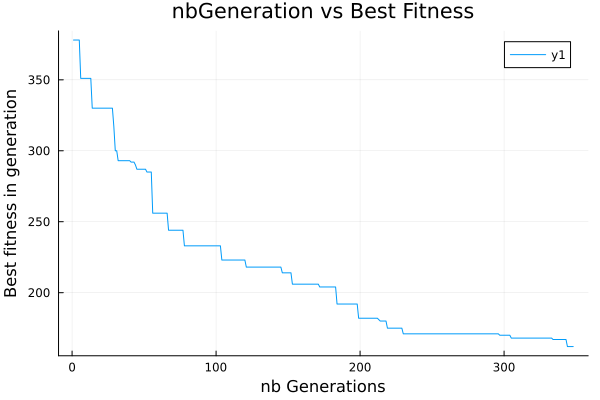

In [136]:
plot([1:size(fitBest)[1]],fitBest,xlabel="nb Generations",ylabel="Best fitness in generation",title="nbGeneration vs Best Fitness")

In [129]:
#crossover complique
println("crossover avec matrice de couleurs")
tournamentSize=2 
tauxElitisme=0.2 #crossover Rate
probMutation=0.1 # probabilite de mutation
nbGenerationMax=2000
popSize=25 #population size
flag=2 #roue de fortune =2, tournament =1 

geneticColoring_cr, fitBest,fitAvg, nbGen=GeneticCross(popSize,nbGenerationMax,probMutation,tauxElitisme,tournamentSize,adjacence_list,sommetsSort,n,k,flag)
println("crossover plus complique ",countConflict(adjacence_list,geneticColoring_cr,n))




crossover plus complique 363.0


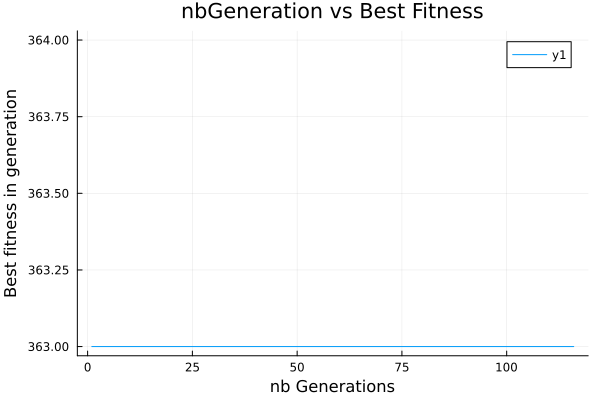

In [130]:
plot([1:size(fitBest)[1]],fitBest,xlabel="nb Generations",ylabel="Best fitness in generation",title="nbGeneration vs Best Fitness")


In [146]:
solutions=zeros(Int,10)

num_iterations = 10
total_time = @elapsed begin
    for i=1:10
        @time begin
            geneticColoring, fitBest,fitAvg, nbGen=Genetic(popSize,nbGenerationMax,probMutation,tauxElitisme,tournamentSize,adjacence_list,sommetsSort,n,k,2)
        end
        solutions[i]=countConflict(adjacence_list,geneticColoring,n)

    end
end


average_time = total_time / num_iterations
println(solutions)
println("temps Moyenne: ", average_time, " seconds")

100.501066 seconds (9.12 M allocations: 2.562 GiB, 0.38% gc time)


 94.682757 seconds (9.12 M allocations: 2.562 GiB, 0.40% gc time)


 88.495921 seconds (9.12 M allocations: 2.562 GiB, 0.44% gc time)
